# `causalml` - Meta-Learner Example Notebook

# Introduction
CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data. Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form.  The package currently supports the following methods:
- Tree-based algorithms
    - Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
    - Uplift tree/random forests on Contextual Treatment Selection
- Meta-learner algorithms
    - S-learner
    - T-learner
    - X-learner
    - R-learner
    
In this notebook, we will generate some synthetic data to demonstrate how to use the various Meta-Learner algorithms in order to estimate Individual Treatment Effects (and Average Treatment Effects with confidence intervals).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

/Users/jeong/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import causalml
print(causalml.__version__)

0.7.0


# Part A: Example Workflow using Synthetic Data

### Generate synthetic data
- We have implemented 4 modes of generating synthetic data (specified by input parameter `mode`). Refer to the References section for more detail on these data generation processes.

In [4]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

### Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [5]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.6841716]), array([0.63612064]), array([0.73222256]))
ATE estimate: 0.684
ATE lower bound: 0.636
ATE upper bound: 0.732


In [6]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.54211262]), array([0.51688401]), array([0.56734124]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.54211262]), array([0.51688401]), array([0.56734124]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.67178423]), array([0.63091207]), array([0.7126564]))


In [7]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.49851986]), array([0.47623108]), array([0.52080863]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.67178423]), array([0.63091207]), array([0.7126564]))


In [8]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.5012156]), array([0.4789358]), array([0.52349541]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.67178423]), array([0.63091207]), array([0.7126564]))


In [9]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.49372109]), array([0.49325113]), array([0.49419105]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.49241981]), array([0.49200397]), array([0.49283564]))


In [10]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.49627422]), array([0.49580464]), array([0.49674381]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.57259201]), array([0.57217679]), array([0.57300724]))


### 7. Calculate Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [11]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

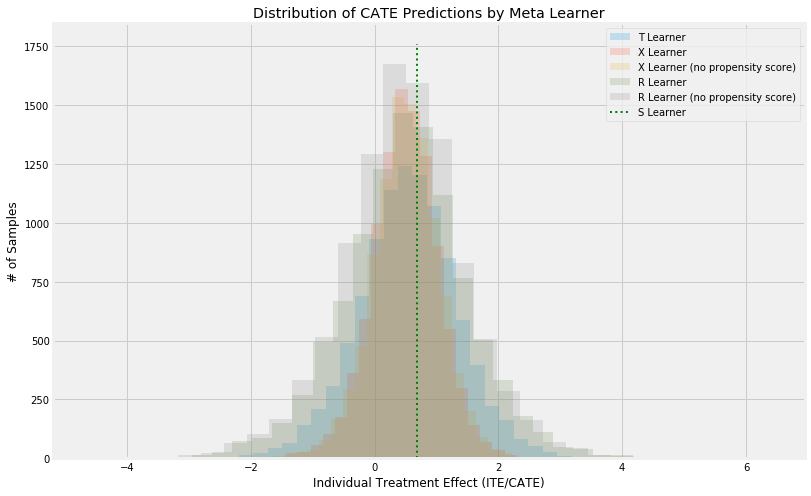

In [12]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

# Part B: Validating Meta-Learner Accuracy

We will validate the meta-learners' performance based on the same synthetic data generation method in Part A (`simulate_nuisance_and_easy_treatment`).

In [13]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [14]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.369825,0.076271,3.764605
S Learner (XGB),0.080101,0.099250,0.279357
T Learner (LR),0.347580,0.035683,0.299882
T Learner (XGB),0.071162,0.585525,0.988301
X Learner (LR),0.347580,0.035683,0.299882
X Learner (XGB),0.061055,0.260532,0.562423
R Learner (LR),0.285530,0.036502,0.294882
R Learner (XGB),0.166203,0.830898,1.090419


In [15]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.369424,0.076723,3.779835
S Learner (XGB),0.085734,0.094064,0.288874
T Learner (LR),0.348084,0.035861,0.330073
T Learner (XGB),0.082944,0.377268,0.802527
X Learner (LR),0.348084,0.035861,0.330073
X Learner (XGB),0.060982,0.189280,0.436895
R Learner (LR),0.286238,0.036814,0.325032
R Learner (XGB),0.166859,0.533547,0.897463


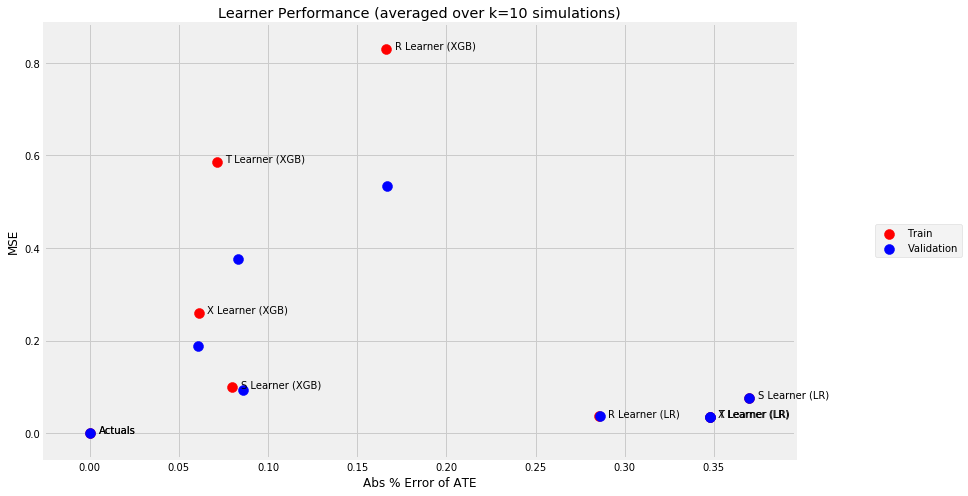

In [16]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

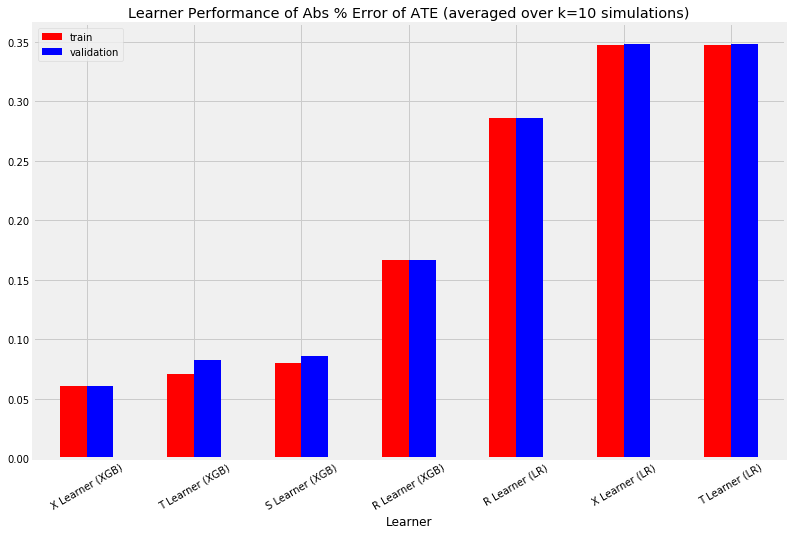

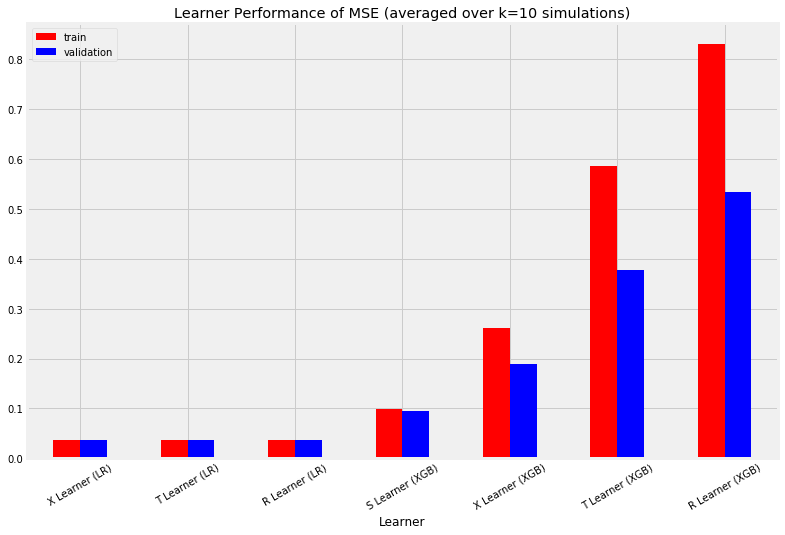

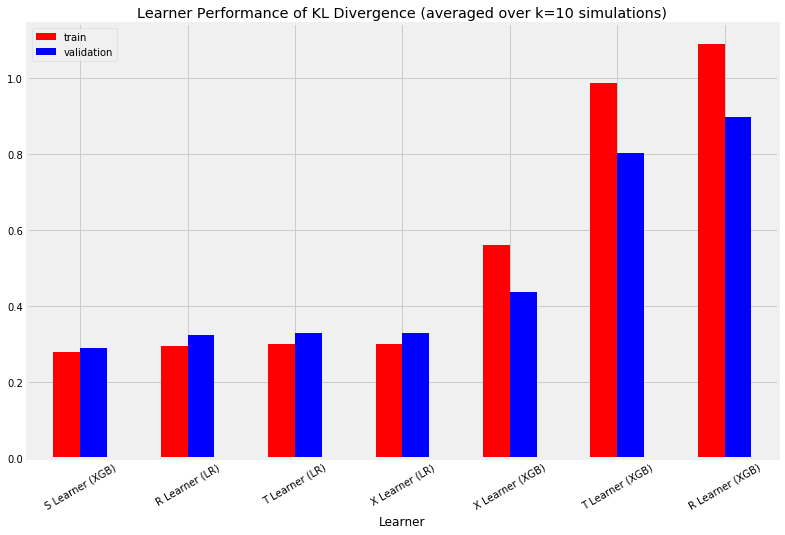

In [17]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [18]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

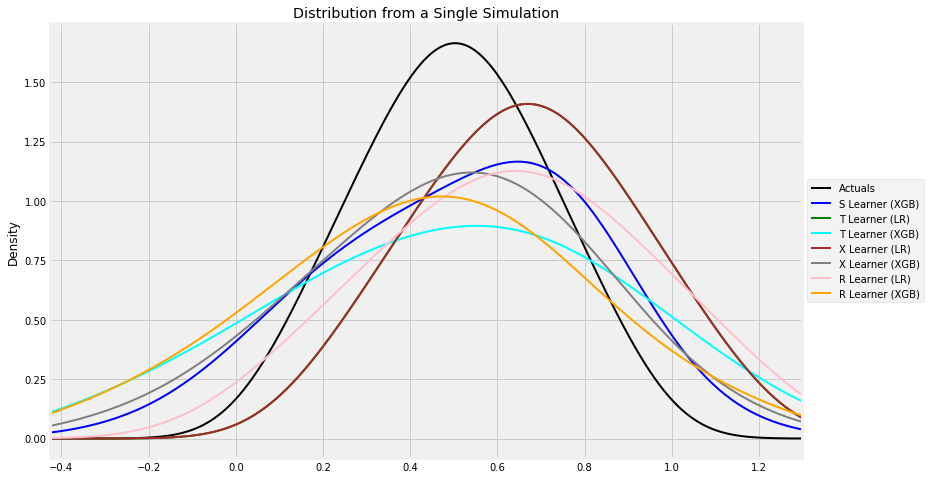

In [19]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

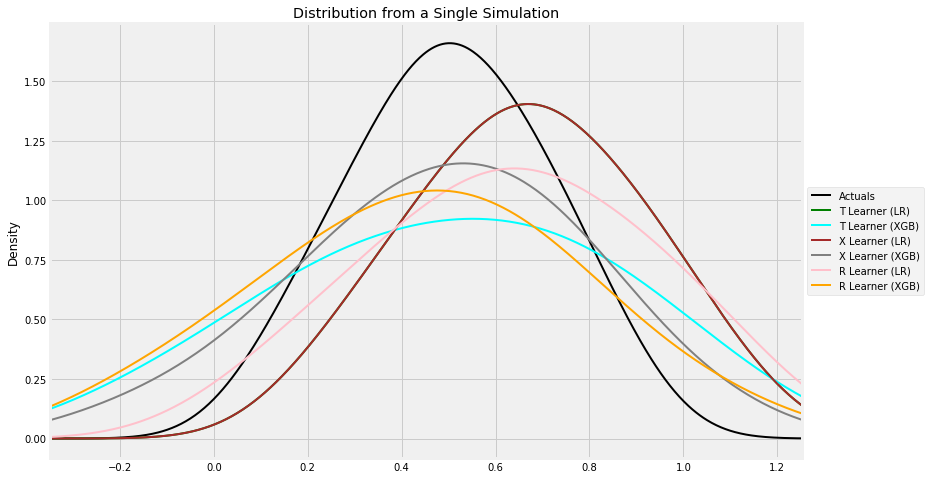

In [20]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

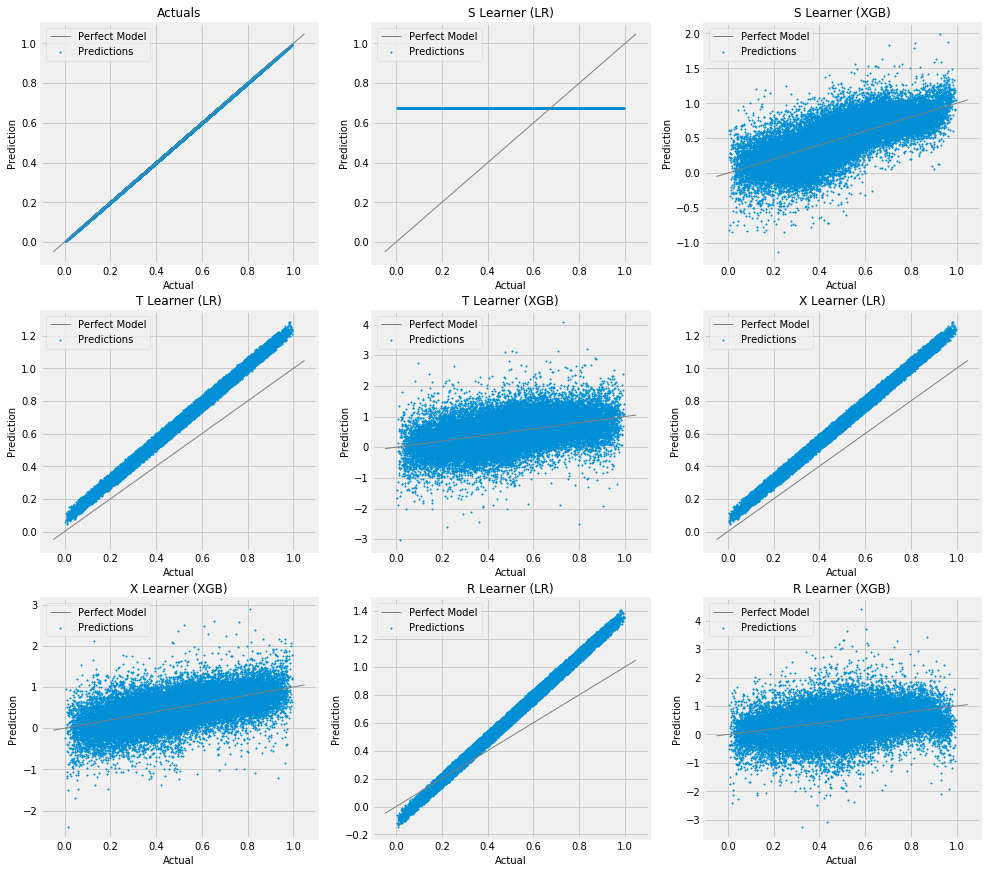

In [21]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

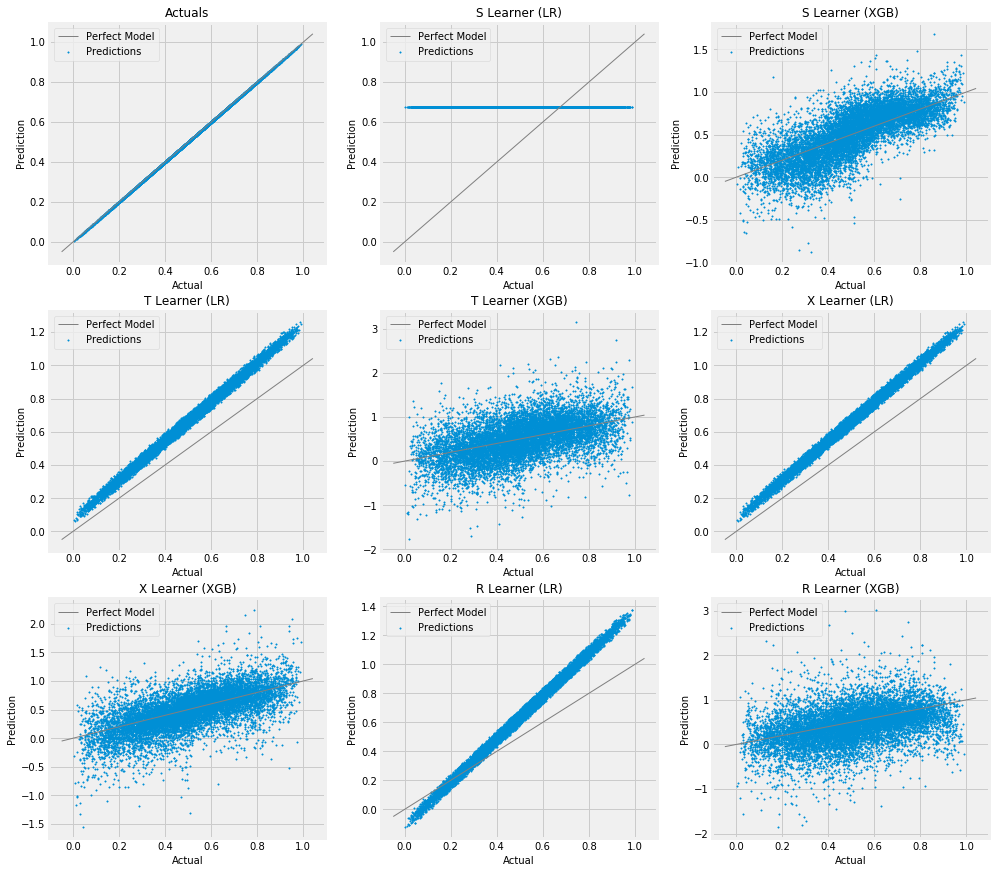

In [22]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,4.934373e+06
6,R Learner (LR),4.931629e+06
2,T Learner (LR),4.931320e+06
4,X Learner (LR),4.931320e+06
1,S Learner (XGB),4.715396e+06
5,X Learner (XGB),4.599402e+06
3,T Learner (XGB),4.469742e+06
7,R Learner (XGB),4.376875e+06
8,Random,3.997457e+06


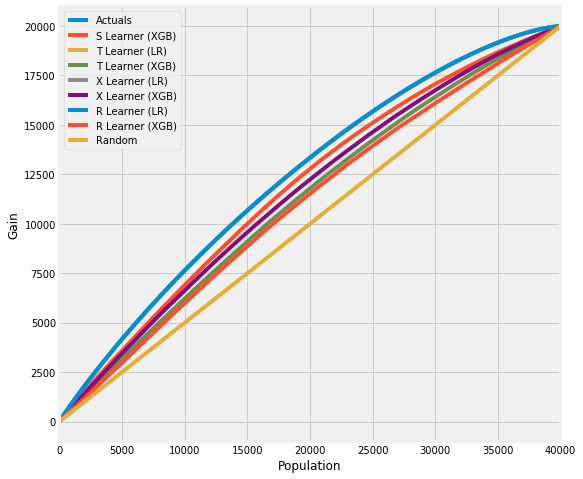

In [23]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,309245.513996
6,R Learner (LR),309074.622503
2,T Learner (LR),309058.015949
4,X Learner (LR),309058.015949
1,S Learner (XGB),296177.114765
5,X Learner (XGB),290009.178366
3,T Learner (XGB),281526.223868
7,R Learner (XGB),275794.397902
8,Random,250952.171678


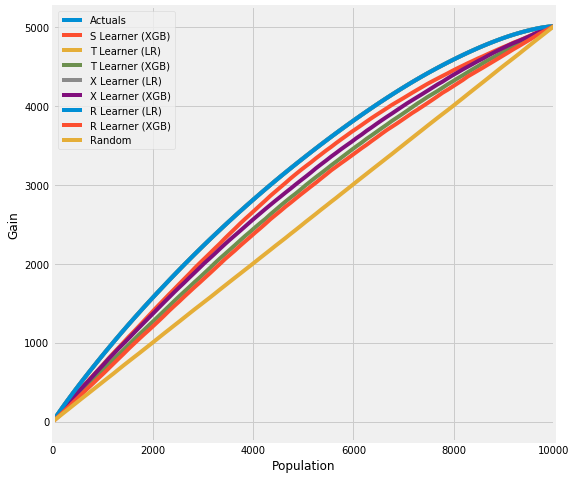

In [24]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])